Authors:

- Kacper Kuźnik 75267
- Mikołaj Nowacki 75231

In [ ]:
!pip install datasets
!pip install transformers
!pip install timm
!pip install wandb
!pip install matplotlib
!pip install albumentations
!pip install pycocotools
!pip install torchmetrics
!pip install ultralytics
!pip install supervision
!pip install roboflow


Imports and Device setup

In [ ]:
# !pip install --upgrade transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 68.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2


In [ ]:
# !pip install --upgrade torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 733.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17

In [ ]:
import torch
import numpy as np
from tqdm.notebook import tqdm  # specific tqdm for notebooks
from torchvision.datasets import VOCDetection
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from ultralytics import YOLO
from transformers import DetrImageProcessor, DetrForObjectDetection
# from transformers import RtDetrImageProcessor, RtDetrForObjectDetection
from transformers import AutoImageProcessor, AutoModelForObjectDetection # !!! TEMPORARY FIX
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# PASCAL VOC Classes (20 classes)
VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

# COCO Classes (80 classes)
COCO_CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'hair drier', 'toothbrush'
]

# Format: COCO_NAME: VOC_NAME
NAME_MAPPING = {
    'airplane': 'aeroplane', 'motorcycle': 'motorbike', 'dining table': 'diningtable',
    'potted plant': 'pottedplant', 'couch': 'sofa', 'tv': 'tvmonitor'
}

# Create a translation dictionary: COCO_ID -> VOC_ID
COCO_ID_TO_VOC_ID = {}
for coco_id, coco_name in enumerate(COCO_CLASSES):
    voc_name = NAME_MAPPING.get(coco_name, coco_name)
    if voc_name in VOC_CLASSES:
        COCO_ID_TO_VOC_ID[coco_id] = VOC_CLASSES.index(voc_name)
    else:
        COCO_ID_TO_VOC_ID[coco_id] = None

print("Class mapping created successfully.")

Class mapping created successfully.


In [ ]:
class ModelWrapper:
    def __init__(self, name, device):
        self.name = name
        self.device = device

    def predict(self, image):
        raise NotImplementedError

class YOLOv11Wrapper(ModelWrapper):
    def __init__(self, device):
        super().__init__("YOLOv11", device)
        self.model = YOLO('yolo11n.pt')

    def predict(self, image):
        results = self.model.predict(image, verbose=False)[0]
        boxes = results.boxes.xyxy.cpu()
        scores = results.boxes.conf.cpu()
        labels = results.boxes.cls.cpu().int()
        return boxes, scores, labels

class DETRWrapper(ModelWrapper):
    def __init__(self, device):
        super().__init__("DETR", device)
        self.processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
        self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").to(device)

    def predict(self, image):
        inputs = self.processor(images=image, return_tensors="pt").to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs)

        target_sizes = torch.tensor([image.size[::-1]]).to(self.device)
        results = self.processor.post_process_object_detection(outputs, target_sizes=target_sizes)[0]
        return results['boxes'].cpu(), results['scores'].cpu(), results['labels'].cpu()

# class RTDETRWrapper(ModelWrapper):
#     def __init__(self, device):
#         super().__init__("RT-DETR", device)
#         self.processor = RtDetrImageProcessor.from_pretrained("PekingU/rtdetr_r18vd")
#         self.model = RtDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r18vd").to(device)

#     def predict(self, image):
#         inputs = self.processor(images=image, return_tensors="pt").to(self.device)
#         with torch.no_grad():
#             outputs = self.model(**inputs)

#         target_sizes = torch.tensor([image.size[::-1]]).to(self.device)
#         results = self.processor.post_process_object_detection(outputs, target_sizes=target_sizes)[0]
#         return results['boxes'].cpu(), results['scores'].cpu(), results['labels'].cpu()

# --- RT-DETR Wrapper using Auto Classes ---
class RTDETRWrapper:
    def __init__(self, device):
        self.name = "RT-DETR"
        self.device = device
        # Load using Auto classes
        self.processor = AutoImageProcessor.from_pretrained("PekingU/rtdetr_r18vd")
        self.model = AutoModelForObjectDetection.from_pretrained("PekingU/rtdetr_r18vd").to(device)

    def predict(self, image):
        inputs = self.processor(images=image, return_tensors="pt").to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs)

        target_sizes = torch.tensor([image.size[::-1]]).to(self.device)
        results = self.processor.post_process_object_detection(outputs, target_sizes=target_sizes)[0]
        return results['boxes'].cpu(), results['scores'].cpu(), results['labels'].cpu()

In [ ]:
def evaluate_model(model_wrapper, dataset, num_samples=1000, conf_threshold=0.5):
    metric = MeanAveragePrecision(iou_type="bbox")
    total_detections = 0

    print(f"\n--- Evaluating {model_wrapper.name} (Conf Thresh: {conf_threshold}) ---")

    if hasattr(model_wrapper, 'model') and hasattr(model_wrapper.model, 'config'):
        id2label = model_wrapper.model.config.id2label
    elif hasattr(model_wrapper.model, 'names'):
         id2label = model_wrapper.model.names
    else:
        id2label = {i: name for i, name in enumerate(COCO_CLASSES)}

    # Loop through dataset
    for i in tqdm(range(min(len(dataset), num_samples))):
        image, target_dict = dataset[i]

        # 1. Get Predictions
        pred_boxes, pred_scores, pred_labels = model_wrapper.predict(image)

        valid_boxes = []
        valid_scores = []
        valid_labels = []

        # 2. Filter & Map Classes
        for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
            if score < conf_threshold:
                continue

            # Get string name from model's internal config
            label_idx = int(label.item())
            class_name = id2label.get(label_idx, str(label_idx))

            # Normalize synonyms (COCO -> VOC)
            # 'airplane' -> 'aeroplane', 'couch' -> 'sofa'
            class_name = NAME_MAPPING.get(class_name, class_name)

            # 3. Check if valid VOC class
            if class_name in VOC_CLASSES:
                valid_boxes.append(box)
                valid_scores.append(score)
                # Convert back to VOC ID (0-19)
                valid_labels.append(VOC_CLASSES.index(class_name))

        # Track number of detections for this image
        total_detections += len(valid_boxes)

        # Format for TorchMetrics
        if len(valid_boxes) > 0:
            preds = [{
                "boxes": torch.stack(valid_boxes),
                "scores": torch.tensor(valid_scores),
                "labels": torch.tensor(valid_labels)
            }]
        else:
            preds = [{
                "boxes": torch.tensor([]),
                "scores": torch.tensor([]),
                "labels": torch.tensor([])
            }]

        # 3. Parse Ground Truth
        gt_boxes = []
        gt_labels = []
        objects = target_dict['annotation']['object']
        if not isinstance(objects, list):
            objects = [objects]

        for obj in objects:
            name = obj['name']
            bndbox = obj['bndbox']
            bbox = [
                float(bndbox['xmin']), float(bndbox['ymin']),
                float(bndbox['xmax']), float(bndbox['ymax'])
            ]
            gt_boxes.append(bbox)
            gt_labels.append(VOC_CLASSES.index(name))

        targets = [{
            "boxes": torch.tensor(gt_boxes),
            "labels": torch.tensor(gt_labels)
        }]

        metric.update(preds, targets)

    # Compute final metrics
    result = metric.compute()
    avg_detections = total_detections / min(len(dataset), num_samples)

    return result, avg_detections

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# in Colab's FileExplorer: ../content/drive/<my drive files>

Mounted at /content/drive


In [ ]:
# Load Dataset
print("Loading PASCAL VOC 2007 Val set...")
# dataset = VOCDetection('data/', year="2007", image_set="val", download=False)
dataset = VOCDetection('/content/drive/MyDrive/CV-project/data', year="2007", image_set="val", download=False)
print(f"Dataset loaded. Total images: {len(dataset)}")

Loading PASCAL VOC 2007 Val set...
Dataset loaded. Total images: 2510


In [ ]:
import warnings

# Initialize Models
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning, message=".*copying from a non-meta parameter.*")
    models = [
        YOLOv11Wrapper(device),
        DETRWrapper(device),
        RTDETRWrapper(device)
    ]

thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

results_log = {} # Dictionary to store results for later analysis

for conf in thresholds:
    print(f"\n{'='*40}")
    print(f"  RUNNING EXPERIMENT WITH CONFIDENCE: {conf}")
    print(f"{'='*40}")

    for model in models:
        # Get both mAP and Avg Detections
        metrics, avg_det = evaluate_model(model, dataset, num_samples=1000, conf_threshold=conf)

        # Store data
        if model.name not in results_log: results_log[model.name] = []
        results_log[model.name].append((conf, metrics['map_50'], avg_det))

        print(f"Results for {model.name}:")
        print(f"  mAP (50):       {metrics['map_50']:.4f}")
        print(f"  Avg Detections: {avg_det:.2f}")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



  RUNNING EXPERIMENT WITH CONFIDENCE: 0.1

--- Evaluating YOLOv11 (Conf Thresh: 0.1) ---


  0%|          | 0/1000 [00:00<?, ?it/s]

Results for YOLOv11:
  mAP (50):       0.7178
  Avg Detections: 3.28

--- Evaluating DETR (Conf Thresh: 0.1) ---


  0%|          | 0/1000 [00:00<?, ?it/s]

Results for DETR:
  mAP (50):       0.7934
  Avg Detections: 5.77

--- Evaluating RT-DETR (Conf Thresh: 0.1) ---


  0%|          | 0/1000 [00:00<?, ?it/s]

Results for RT-DETR:
  mAP (50):       0.7491
  Avg Detections: 3.06

  RUNNING EXPERIMENT WITH CONFIDENCE: 0.3

--- Evaluating YOLOv11 (Conf Thresh: 0.3) ---


  0%|          | 0/1000 [00:00<?, ?it/s]

Results for YOLOv11:
  mAP (50):       0.7064
  Avg Detections: 3.01

--- Evaluating DETR (Conf Thresh: 0.3) ---


  0%|          | 0/1000 [00:00<?, ?it/s]

Results for DETR:
  mAP (50):       0.7934
  Avg Detections: 5.77

--- Evaluating RT-DETR (Conf Thresh: 0.3) ---


  0%|          | 0/1000 [00:00<?, ?it/s]

Results for RT-DETR:
  mAP (50):       0.7491
  Avg Detections: 3.06

  RUNNING EXPERIMENT WITH CONFIDENCE: 0.5

--- Evaluating YOLOv11 (Conf Thresh: 0.5) ---


  0%|          | 0/1000 [00:00<?, ?it/s]

Results for YOLOv11:
  mAP (50):       0.6180
  Avg Detections: 2.21

--- Evaluating DETR (Conf Thresh: 0.5) ---


  0%|          | 0/1000 [00:00<?, ?it/s]

Results for DETR:
  mAP (50):       0.7934
  Avg Detections: 5.77

--- Evaluating RT-DETR (Conf Thresh: 0.5) ---


  0%|          | 0/1000 [00:00<?, ?it/s]

Results for RT-DETR:
  mAP (50):       0.7491
  Avg Detections: 3.06

  RUNNING EXPERIMENT WITH CONFIDENCE: 0.7

--- Evaluating YOLOv11 (Conf Thresh: 0.7) ---


  0%|          | 0/1000 [00:00<?, ?it/s]

Results for YOLOv11:
  mAP (50):       0.4703
  Avg Detections: 1.51

--- Evaluating DETR (Conf Thresh: 0.7) ---


  0%|          | 0/1000 [00:00<?, ?it/s]

Results for DETR:
  mAP (50):       0.7826
  Avg Detections: 4.67

--- Evaluating RT-DETR (Conf Thresh: 0.7) ---


  0%|          | 0/1000 [00:00<?, ?it/s]

Results for RT-DETR:
  mAP (50):       0.6395
  Avg Detections: 2.17

  RUNNING EXPERIMENT WITH CONFIDENCE: 0.9

--- Evaluating YOLOv11 (Conf Thresh: 0.9) ---


  0%|          | 0/1000 [00:00<?, ?it/s]

Results for YOLOv11:
  mAP (50):       0.1279
  Avg Detections: 0.32

--- Evaluating DETR (Conf Thresh: 0.9) ---


  0%|          | 0/1000 [00:00<?, ?it/s]

Results for DETR:
  mAP (50):       0.7423
  Avg Detections: 3.34

--- Evaluating RT-DETR (Conf Thresh: 0.9) ---


  0%|          | 0/1000 [00:00<?, ?it/s]

Results for RT-DETR:
  mAP (50):       0.3593
  Avg Detections: 0.97


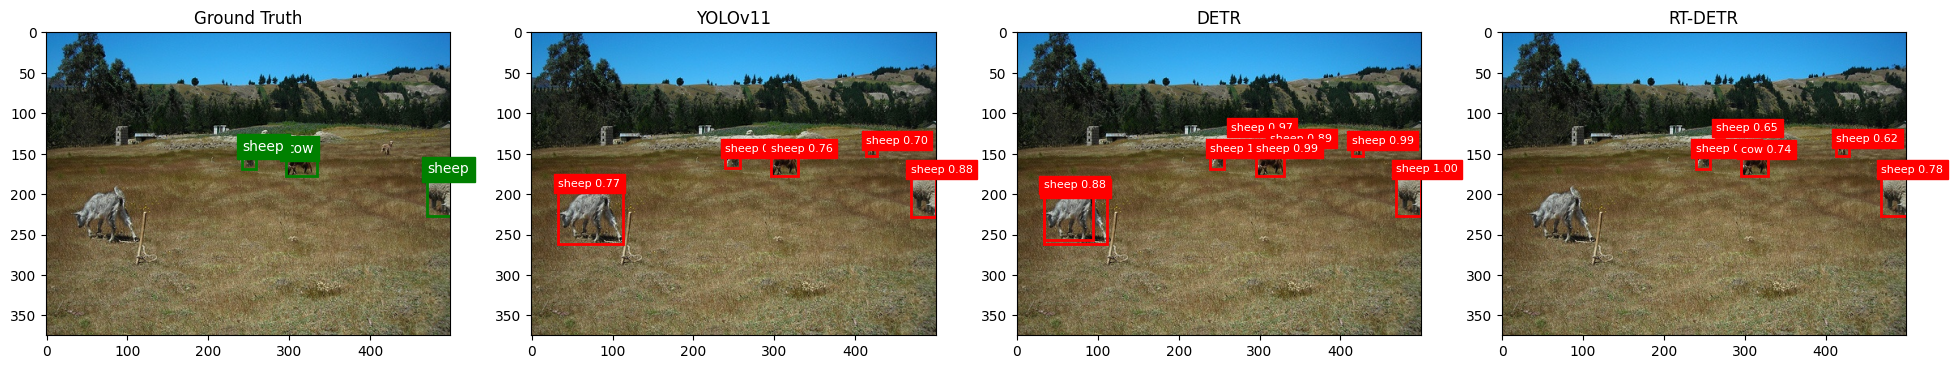

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_comparison(dataset, models, image_index=0, conf_threshold=0.5):
    image, target = dataset[image_index]
    fig, axes = plt.subplots(1, len(models) + 1, figsize=(24, 6))

    # Plot Ground Truth
    axes[0].imshow(image)
    axes[0].set_title("Ground Truth")
    objects = target['annotation']['object']
    if not isinstance(objects, list): objects = [objects]

    for obj in objects:
        box = obj['bndbox']
        rect = patches.Rectangle(
            (float(box['xmin']), float(box['ymin'])),
            float(box['xmax']) - float(box['xmin']),
            float(box['ymax']) - float(box['ymin']),
            linewidth=2, edgecolor='g', facecolor='none'
        )
        axes[0].add_patch(rect)
        axes[0].text(float(box['xmin']), float(box['ymin']), obj['name'],
                     color='white', backgroundcolor='green')

    # Plot Models
    for i, model in enumerate(models):
        ax = axes[i+1]
        ax.imshow(image)
        ax.set_title(f"{model.name}")

        if hasattr(model, 'model') and hasattr(model.model, 'config'):
            id2label = model.model.config.id2label
        elif hasattr(model.model, 'names'):
            id2label = model.model.names
        else:
            id2label = {i: name for i, name in enumerate(COCO_CLASSES)}

        boxes, scores, labels = model.predict(image)

        for box, score, label in zip(boxes, scores, labels):
            if score < conf_threshold: continue

            # Map label to string
            label_idx = int(label.item())
            name = id2label.get(label_idx, str(label_idx))
            name = NAME_MAPPING.get(name, name)

            # Filter only VOC classes
            if name not in VOC_CLASSES: continue

            x1, y1, x2, y2 = box.tolist()
            w, h = x2 - x1, y2 - y1

            rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1, f"{name} {score:.2f}", color='white', backgroundcolor='red', fontsize=8)

    plt.show()

# Run visualization on a specific image
visualize_comparison(dataset, models, image_index=25, conf_threshold=0.5)